### TO DO:

- Clean up the directory and commit and push
- Try colour binning. 

In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os
import time
import json

%matplotlib inline

In [2]:
from file_processing import cbir_compress_and_save, get_filenames

In [3]:
dataset_path = 'data/segmentation/'

In [4]:
files = get_filenames(dataset_path)

In [65]:
for i, f in enumerate(files):
    cbir_compress_and_save(os.path.join(dataset_path, f), os.path.join(dataset_path, f))

In [5]:
def draw(rects,color, ax):
    img_copy = img.copy()
    for r in rects:
        p1 = (r[0], r[1])
        p2 = (r[0]+r[2], r[1]+r[3])
        cv2.rectangle(img_copy, p1,p2, color,4)
    ax.imshow(img_copy)
    ax.set_title("Grouped rectangles")

In [ ]:
# Contrast - I mabe kind of want the opposite?
#     alpha = 0.5
#     beta = 0
#     mask = np.zeros(img.shape, img.dtype)
#     for y in range(img.shape[0]):
#         for x in range(img.shape[1]):
#             for c in range(img.shape[2]):
#                 mask[y,x,c] = np.clip(alpha*img[y,x,c] + beta, 0, 255)
#     ax[0, 0].imshow(mask)
#     ax[0, 0].set_title("Contrast")

In [ ]:
    # Blur
#     mask = cv2.medianBlur(morph, 5)
#     ax[2, 0].imshow(mask, cmap='gray')
#     ax[2, 0].set_title("Blur")

In [ ]:
#     mask = gray
#     mask = cv2.addWeighted(mask, 1.5, gray, -0.5, 0)
#     ax[0, 0].imshow(mask, cmap='gray')
#     ax[0, 0].set_title("Sharpen")
    
    # binarize
#     edged = cv2.Canny(gray,30,200)
#     ret, edged = cv2.threshold(gray,127,255,cv2.THRESH_BINARY_INV)
#     ret, mask = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

In [ ]:
    # Erode
    # mask = cv2.erode(mask,kernel,iterations = 5) 

In [ ]:
    # struggles when the holds are similar colour to the background
    # chalky holds are a problem! The algo finds the cointour of chalkiness basically
    # but maybe only up close?
    # coloured walls might be a problem
    # the outside boulder is particularly bad. Why? Even though the colour is obvious. Should try colour as well. 

In [101]:
def remove_shadow(img):
    
    fig, ax = plt.subplots(2, 2, figsize=(15,5))
    
    ax[0, 0].imshow(img)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)   
    mask = cv2.dilate(img, np.ones((21, 21), np.uint8)) 
    ax[0, 1].imshow(mask)
    mask = cv2.GaussianBlur(mask,(5,5),0)
    ax[1, 0].imshow(mask)
    diff_img = 255 - cv2.absdiff(img, mask)
    ax[1, 1].imshow(diff_img)
    plt.show()
    
    return diff_img

In [102]:
def process_image(img):


    shadow = remove_shadow(img)
    
    fig, ax = plt.subplots(4, 2, figsize=(15,25))
    
    # grayscale
    gray = cv2.cvtColor(shadow, cv2.COLOR_BGR2GRAY)
#     ax[0, 0].imshow(gray, cmap='gray')
#     ax[0, 0].set_title("Gray")


    mask = cv2.GaussianBlur(gray,(5,5),0)
    ax[0, 0].imshow(mask, cmap='gray')
    ax[0, 0].set_title("Gaussian Blur")

    mask = cv2.adaptiveThreshold(mask, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 301, 20)
    ax[0, 1].imshow(mask, cmap='gray')
    ax[0, 1].set_title("Binarise")
    
    # the kernel will affect the resulting shapes. (1, 10) will give horizontal features and (10, 1) vertical. 
    # the bigger the kernel, the coarser the features.
    # (2, 2) had the rectangles a bit off the features
    # "Structuring elements with even size lead to shifts, there is no middle pixel. 
    # With an odd size, you get a middle pixel and (n-1)/2 pixels at each size."
    kernel = np.ones((1, 3), np.uint8)  
    
    # morphology
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=4)  
    ax[1, 0].imshow(mask, cmap='gray')
    ax[1, 0].set_title("Morphology OPEN")
    
    # morphology
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=5)  
    ax[1, 1].imshow(mask, cmap='gray')
    ax[1, 1].set_title("Morphology CLOSE")

    # Contours
    contours, hierarchy=cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    x = cv2.drawContours(img.copy(),contours,-1,(0,255,0),3)
    ax[2, 0].imshow(x)
    ax[2, 0].set_title("Contours")
    
    # Convex Hull
    img_copy = img.copy()
    for c in contours:
        hull=cv2.convexHull(c)
        cv2.drawContours(img_copy,[hull],0,(0,255,0),2)
    ax[2, 1].imshow(img_copy)
    ax[2, 1].set_title("Convex Hulls")
    
    # Rectangles
    img_copy = img.copy()
    rs = []
    for c in contours:
        x,y,w,h=cv2.boundingRect(c)
        rs.append([x,y,w,h])
        cv2.rectangle(img_copy,(x,y),(x+w,y+h),(0,0,255),2)
    ax[3, 0].imshow(img_copy)
    ax[3, 0].set_title("Rectangles")
    
    l = len(rs)
    for r in range(l):
        rs.append(rs[r])
        
    # min cluster size = 2, min distance = 0.5:    
    rects, weights = cv2.groupRectangles(rs, 1, 0.5)
    
    draw(rects, (0,0,255), ax[3, 1])

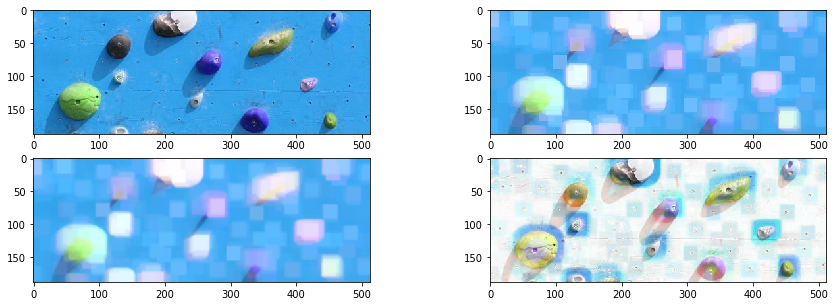

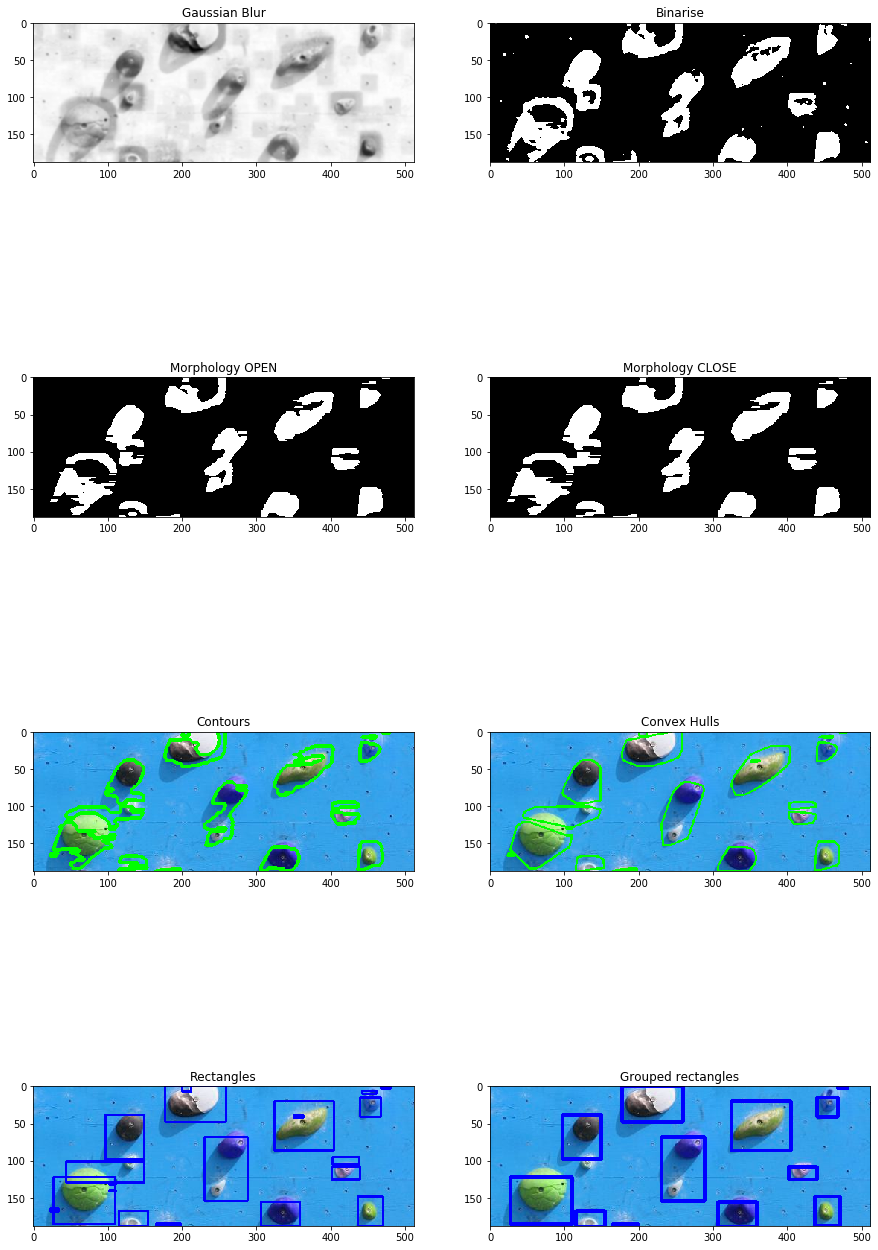

In [103]:
process_image(img)

In [96]:
for n, f in enumerate(files):
    print(f"{n}: {f}")

0: wall.jpeg
1: image-asset.jpeg
2: IMG_0660_cropped.jpeg
3: IMG_20191009_215222636.jpg
4: Bouldering-room-DW-2018-27.jpeg
5: IMG_20191009_215423002.jpg
6: 76778.jpeg
7: WhatsApp Image 2019-10-09 at 22.49.24.jpeg
8: maxresdefault.jpeg
9: WhatsApp Image 2019-10-09 at 22.49.24 (1).jpeg
10: WhatsApp Image 2019-10-09 at 22.47.59 (1).jpeg
11: x1.jpeg
12: IMG_0660.jpeg
13: IMG_20191009_215215867.jpg
14: Screenshot 2021-03-07 at 17.00.29.png
15: IMG_20191124_204716712.jpg
16: IMG_20191009_215250223.jpg


"Erosions and dilations are typically used to reduce noise in binary images (a side effect of thresholding)."

Apply it on graysclae images!!

Erode, dilate affect the foreground pixels (white) - smaller and larger respectively.

What happens if you apply it to colour images though?

In [97]:
img = cv2.imread(os.path.join(dataset_path, files[0]))

In [109]:
cv2.threshold()

(188, 512, 3)

In [110]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [111]:
gray.shape

(188, 512)

In [113]:
img

array([[[ 71, 161, 226],
        [ 70, 162, 227],
        [ 63, 159, 225],
        ...,
        [ 56, 165, 239],
        [ 56, 165, 239],
        [ 56, 165, 239]],

       [[ 83, 173, 238],
        [ 79, 171, 236],
        [ 71, 167, 233],
        ...,
        [ 55, 164, 238],
        [ 55, 164, 238],
        [ 54, 163, 237]],

       [[ 95, 182, 249],
        [ 88, 177, 244],
        [ 76, 172, 238],
        ...,
        [ 54, 163, 237],
        [ 54, 163, 237],
        [ 54, 163, 237]],

       ...,

       [[ 49, 159, 231],
        [ 49, 159, 231],
        [ 48, 158, 230],
        ...,
        [ 58, 161, 230],
        [ 63, 166, 235],
        [ 59, 162, 231]],

       [[ 48, 159, 231],
        [ 48, 159, 231],
        [ 47, 158, 230],
        ...,
        [ 59, 162, 231],
        [ 63, 166, 235],
        [ 59, 162, 231]],

       [[ 48, 159, 231],
        [ 48, 159, 231],
        [ 47, 158, 230],
        ...,
        [ 56, 159, 228],
        [ 60, 163, 232],
        [ 56, 159, 228]]

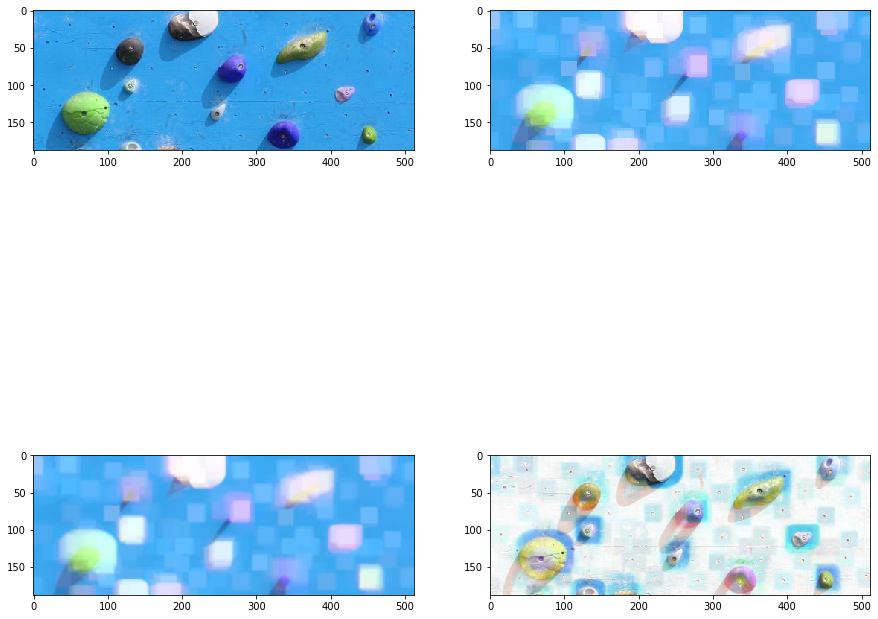

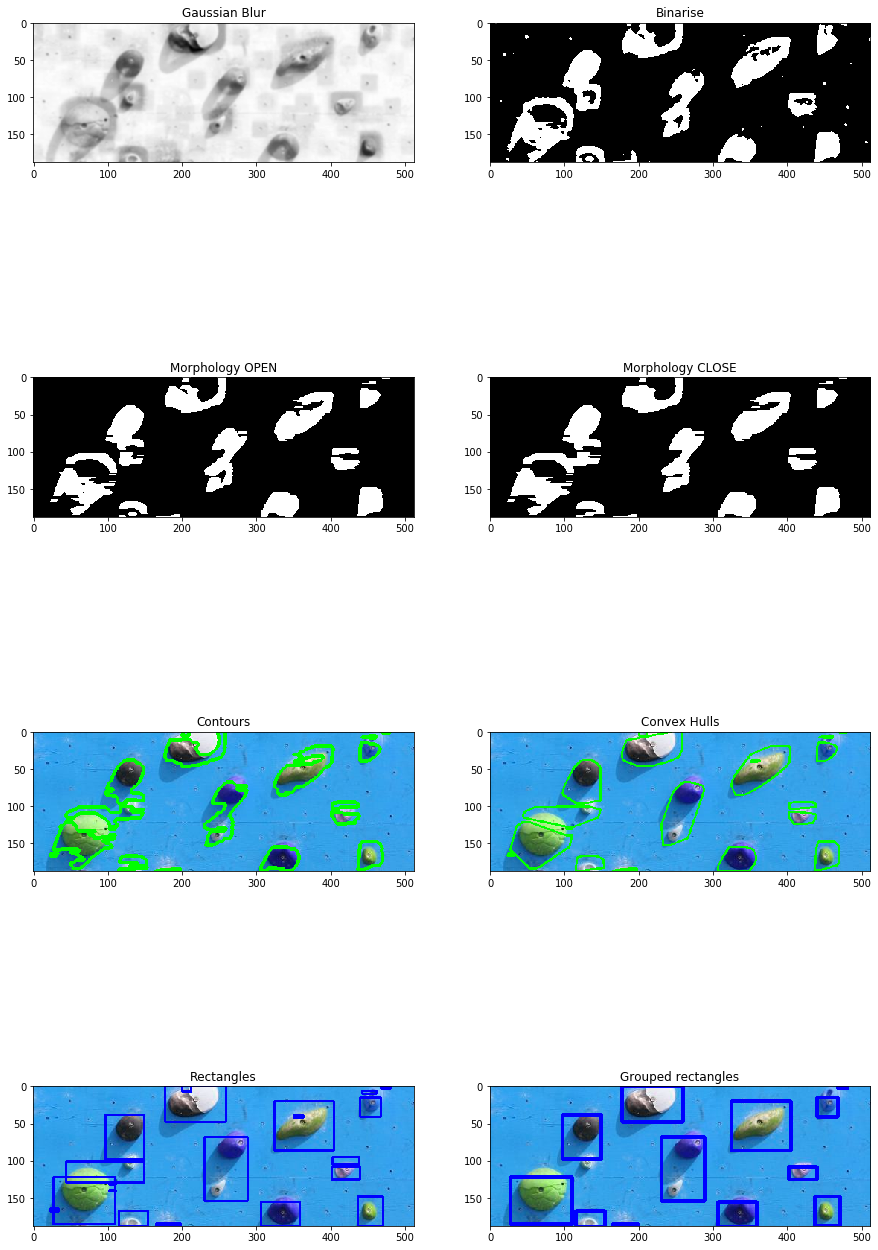

In [98]:
process_image(img)

In [99]:
def evaluate_algo(files):
    num = len(files)
    fig, ax = plt.subplots(num, 2, figsize=(20, num*5))
    
    for n, f in enumerate(files):
        img = cv2.imread(os.path.join(dataset_path, f))
        ax[n, 0].imshow(img)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        mask = cv2.GaussianBlur(gray,(5,5),0)
        mask = cv2.adaptiveThreshold(mask, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 301, 20)
        kernel = np.ones((1, 3), np.uint8)  
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=4)  
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=5)  
        contours, hierarchy=cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        img_copy = img.copy()
        for c in contours:
            hull=cv2.convexHull(c)
            cv2.drawContours(img_copy,[hull],0,(0,255,0),2)
        ax[n, 1].imshow(img_copy)
        ax[n, 0].set_title(f"{f}")

In [106]:
def evaluate_algo(files):
    num = len(files)
    fig, ax = plt.subplots(num, 3, figsize=(30, num*5))
    
    for n, f in enumerate(files):
        img = cv2.imread(os.path.join(dataset_path, f))
        ax[n, 0].imshow(img)
#         gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#         mask = cv2.GaussianBlur(gray,(5,5),0)
#         mask = cv2.adaptiveThreshold(mask, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 301, 20)
#         kernel = np.ones((1, 3), np.uint8)  
#         mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=4)  
#         mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=5)  
#         contours, hierarchy=cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#         img_copy = img.copy()
#         for c in contours:
#             hull=cv2.convexHull(c)
#             cv2.drawContours(img_copy,[hull],0,(0,255,0),2)
#         ax[n, 1].imshow(img_copy)
        ax[n, 0].set_title(f"{f}")
        
        shadow = cv2.dilate(img, np.ones((11, 11), np.uint8))     
        shadow = cv2.medianBlur(shadow, 21)
        shadow = 255 - cv2.absdiff(img, shadow)
        gray = cv2.cvtColor(shadow, cv2.COLOR_BGR2GRAY)
        mask = cv2.GaussianBlur(gray,(5,5),0)
        mask = cv2.adaptiveThreshold(mask, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 301, 20)
        kernel = np.ones((1, 3), np.uint8)  
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=4)  
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=5)  
        contours, hierarchy=cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        img_copy = img.copy()
        for c in contours:
            hull=cv2.convexHull(c)
            cv2.drawContours(img_copy,[hull],0,(0,255,0),2)
        ax[n, 2].imshow(img_copy)

        shadow = cv2.dilate(img, np.ones((11, 11), np.uint8))     
        shadow = cv2.GaussianBlur(shadow,(11,11),0)
        shadow = 255 - cv2.absdiff(img, shadow)
        gray = cv2.cvtColor(shadow, cv2.COLOR_BGR2GRAY)
        mask = cv2.GaussianBlur(gray,(5,5),0)
        mask = cv2.adaptiveThreshold(mask, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 301, 20)
        kernel = np.ones((1, 3), np.uint8)  
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=4)  
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=5)  
        contours, hierarchy=cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        img_copy = img.copy()
        for c in contours:
            hull=cv2.convexHull(c)
            cv2.drawContours(img_copy,[hull],0,(0,255,0),2)
        ax[n, 1].imshow(img_copy)

Not good when:

- Hold colour similar to background
- Chalky holds blend with the background



In [107]:
evaluate_algo(files)

Finding adaptive 

In [845]:
def adaptive(img, block, C):
    print(block, C)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    mask = cv2.GaussianBlur(gray,(5,5),0)
    mask = cv2.adaptiveThreshold(mask, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, block, C)
    plt.imshow(mask)  
    plt.show()

In [848]:
def find_adaptive_coefs(img):
    blocks = [201, 301]
    Cs = [10, 20, 30]
    
    combs = []
    for b in blocks:
        for c in Cs:
            combs.append((b, c))
            
    plt.imshow(img)  
    plt.show()
    for c in combs:
        adaptive(img, c[0], c[1])

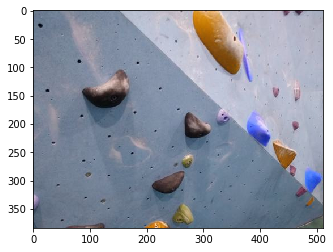

201 10


201 20


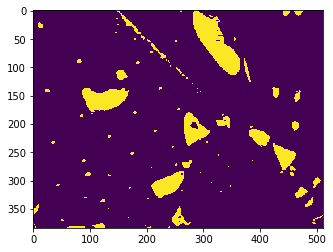

201 30


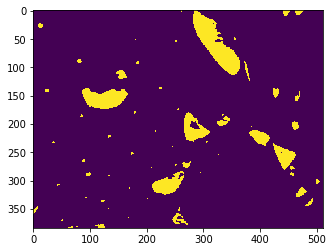

301 10


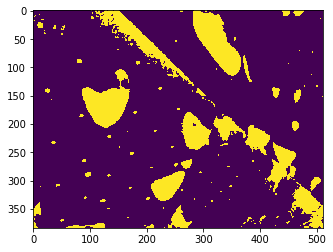

301 20


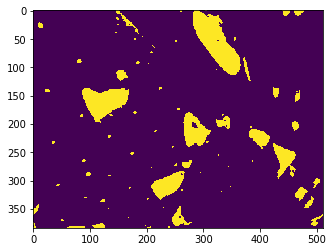

301 30


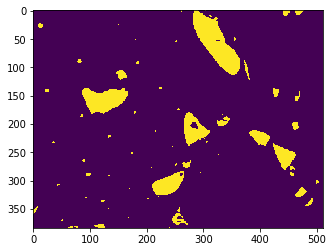

In [850]:
find_adaptive_coefs(img)

In [917]:
def find_sharpen(img, c):

    fig, ax = plt.subplots(1, 2, figsize=(20, 15))
    ax[0].imshow(img)
    mask = cv2.GaussianBlur(img,(5,5),0)
    mask = cv2.addWeighted(img, 1.2, img, 0, 0)  #2nd is just brightness
    ax[1].imshow(mask)
    plt.show() 

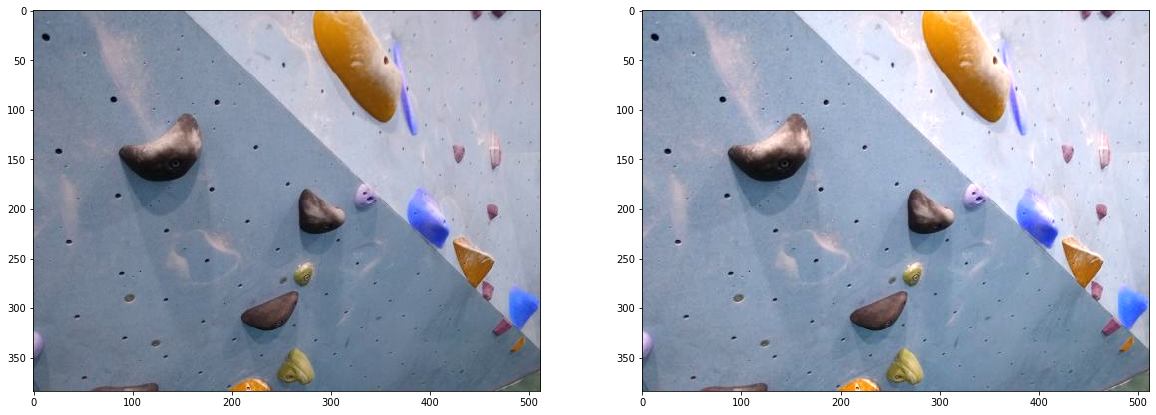

In [918]:
find_sharpen(img, 2)

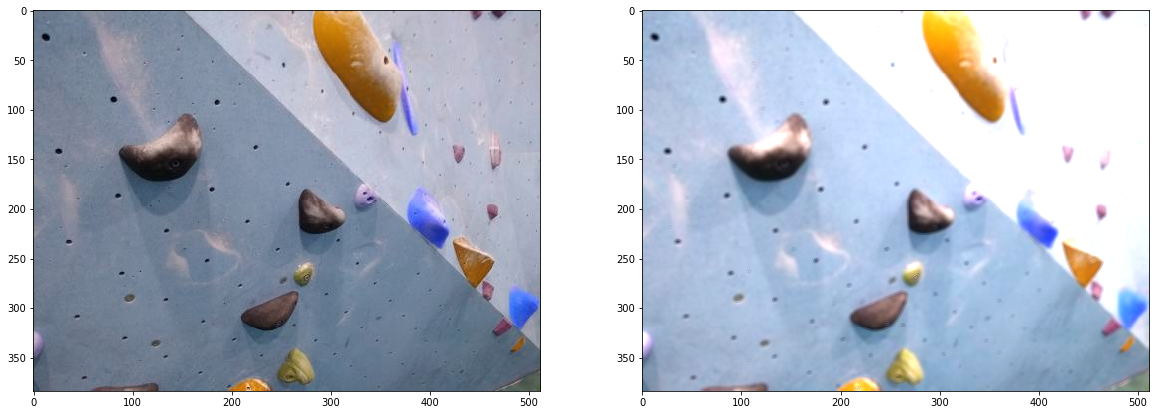

In [897]:
find_sharpen(img, 2)